---

# Initialization

### Imports

In [404]:
import numpy as np
import matplotlib.pyplot as plt
from LRFutils import archive, progress
from src import plot
from scipy.special import wofz
from multiprocess import Pool, cpu_count
import os
import pyvtk as vtk
import psutil

### Constants

In [405]:
h = 6.626196e-27 # erg.s
k = 1.380662e-16 # erg/K
c = 2.99792458e10 # cm/s
pi = np.pi

### Class definitions

In [406]:
class Gas:
    def __init__(
            self,
            f=None,
            profile=None,
            density_cube=None,
            velocity_cube=None,
            v0=None,
            sigma_v=None,
            A12=None,
            B12=None,
            B21=None,
            n_ratio=None,
            emissivity=None,
            absorption=None,

        ):
        self.f = f
        self.profile = profile
        self.density_cube = density_cube
        self.velocity_cube = velocity_cube
        self.v0 = v0
        self.sigma_v = sigma_v
        self.A12 = A12
        self.B12 = B12
        self.B21 = B21
        self.n_ratio = n_ratio
        self.emissivity = emissivity
        self.absorption = absorption

    @property
    def n1(self):
        return self.density_cube - self.density_cube / (self.n_ratio + 1)
    
    @property
    def n2(self):
        return self.density_cube / (self.n_ratio + 1)

### Functions definitions

In [407]:
def gaussian(x, m=0.5, s=0.05):
    return np.exp(- (x - m)**2 / (2 * s**2))

def lorentzian(x, mu, gamma):
    return gamma / (np.pi * ((x - mu)**2 + gamma**2))

def plummer(r, R=0.75):
    return 3/(4*np.pi*R**3)*(1 + r**2 / R**2)**(-5/2)

def voigt_profile(freq_range, sigma, gamma):
    x = freq_range
    y = np.zeros_like(x)
    for i, x_i in enumerate(x):
        z = (x_i + 1j * gamma) / (sigma * np.sqrt(2))
        y[i] = np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))
    return y

def sigmoid(x, d=0.5, l=10):
    return 1/(1+np.exp(-l*(x-d)))

def black_body(f, T):
    return 2 * h * f**3 / c**2 / (np.exp(h * f / k / T) - 1)

def system_info():
    return f"CPU: {psutil.cpu_percent()}%"\
        + f", RAM: {psutil.virtual_memory().percent}%"\
        + f" ({psutil.virtual_memory().used/1024**3:.2f}GB"\
        + f"/ {psutil.virtual_memory().total/1024**3:.2f}GB)"

### Configuration

In [408]:
nb_simu = 1000 # number of generated simulations
# ⚠️ Be carefull, the final dataset will be proportional to nb_images = 6 * nb_simu

# Global
N = 64 # resolution in pixel
r, dr = np.linspace(-1, 1, N, endpoint=True, retstep=True) # range of the space in pc

# Plummer profile (density)
plummer_radius = 0.9 # pc
max_density = 1e6 # hydrogen atom . cm-3    default: 1e6

max_CO_relative_density = 1e-4 # particle / hydrogen atom
max_N2H_relative_density = 1e-7 # particle / hydrogen atom

# Sigmoid parameters (repartition of the gas)
sigmoid_treshold = 0.5e6 # particle.cm-3
sigmoid_slope = 50e-6

# CO
CO = Gas()
CO.v0 = 115.27120e9 # Hz
CO.sigma_v = 1 # cm-1
CO.f = np.linspace(CO.v0 - 10, CO.v0 + 10, N)
CO.profile = gaussian(CO.f, CO.v0, CO.sigma_v)
CO.A21 = 7.203e-8 # s-1
CO.B21 = 2.574e-6 # cm+2 . erg-1 . s-1
CO.B12 = 2.713e-6 # cm+2 . erg-1 . s-1
CO.n_ratio = 3

# N2H+
N2H = Gas()
N2H.v0 = 93.17371e9 # Hz
N2H.sigma_v = 1 # Hz
N2H.f = np.linspace(N2H.v0 - 10, N2H.v0 + 10, N)
N2H.profile = gaussian(N2H.f, N2H.v0, N2H.sigma_v)
N2H.A21 = 3.929e-5 # s-1
N2H.B21 = 1.226e-5 # cm+2 . erg-1 . s-1
N2H.B12 = 2.832e-5 # cm+2 . erg-1 . s-1
N2H.n_ratio = 1# 0.4


### Verification

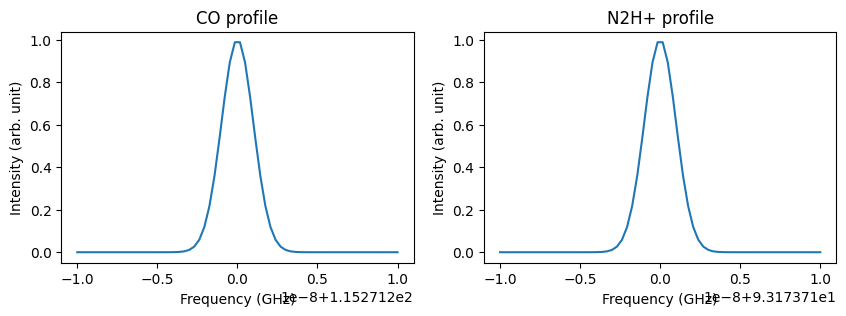

In [409]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(CO.f/1e9, CO.profile)
plt.title("CO profile")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (arb. unit)")
plt.subplot(122)
plt.plot(N2H.f/1e9, N2H.profile)
plt.title("N2H+ profile")
plt.xlabel("Frequency (GHz)")    
plt.ylabel("Intensity (arb. unit)")
plt.show()

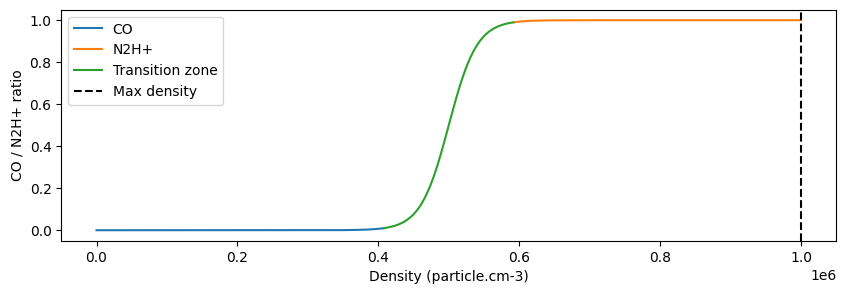

In [410]:
plt.figure(figsize=(10, 3))
tmp = max(max_density, 2*sigmoid_treshold)
tmp = np.linspace(0, tmp, 1000)
tmp2 = sigmoid(tmp, sigmoid_treshold, sigmoid_slope)
plt.plot(tmp[tmp2 < 0.01], tmp2[tmp2 < 0.01], label="CO")
plt.plot(tmp[tmp2 > 0.99], tmp2[tmp2 > 0.99], label="N2H+")
plt.plot(tmp[(tmp2 > 0.01) & (tmp2 < 0.99)], tmp2[(tmp2 > 0.01) & (tmp2 < 0.99)], label="Transition zone")
plt.axvline(max_density, color="k", linestyle="--", label="Max density")
plt.xlabel("Density (particle.cm-3)")
plt.ylabel("CO / N2H+ ratio")
plt.legend()
plt.show()

### Environment variables

In [411]:
X, Y, Z = np.meshgrid(r, r, r)
R = np.sqrt(X**2 + Y**2 + Z**2)

archive_path = archive.new("Generation", verbose=True)

try:
    ncpu = cpu_count()
except:
    with open(os.getenv("OAR_NODEFILE"), 'r') as f:
        ncpu = len(f.readlines())

Archive created at ./archives/2023-03-01_7e946b4/23_Generation


---

# Cloud density generation

In [412]:
p = plummer(R, plummer_radius)
dust_cube = max_density * p / np.max(p)
CO.density_cube = dust_cube * (1 - sigmoid(dust_cube, sigmoid_treshold, sigmoid_slope))
CO. density_cube = max_CO_relative_density * CO.density_cube * np.max(dust_cube) / np.max(CO.density_cube)
N2H.density_cube = dust_cube * sigmoid(dust_cube, sigmoid_treshold, sigmoid_slope)
N2H. density_cube = max_N2H_relative_density * N2H.density_cube * np.max(dust_cube) / np.max(N2H.density_cube)

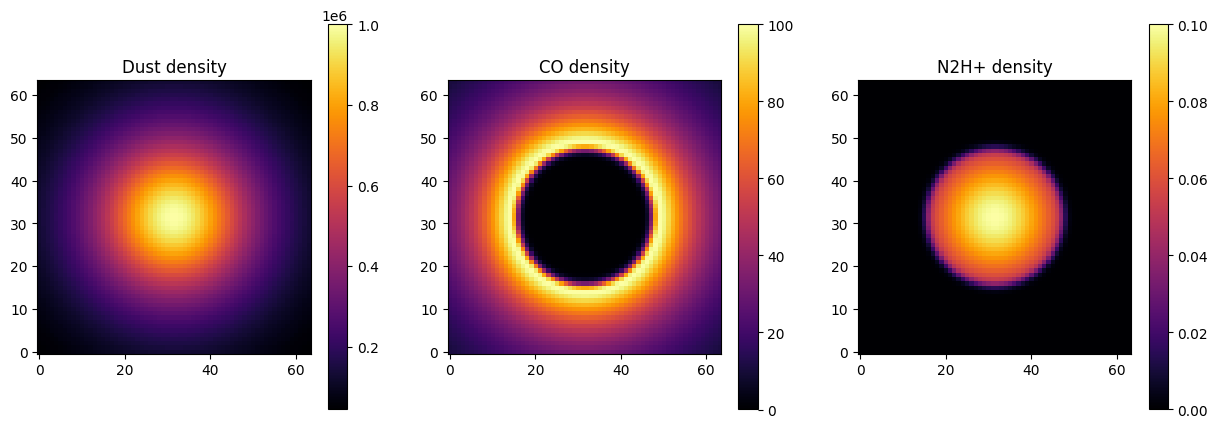

In [413]:
plt.figure(figsize=(15, 5))
plt.subplot(131)    
im = plt.imshow(dust_cube[N//2], origin="lower", cmap="inferno")
plt.colorbar(im)
plt.title("Dust density")
plt.subplot(132)
im = plt.imshow(CO.density_cube[N//2], origin="lower", cmap="inferno")
plt.colorbar(im)
plt.title("CO density")
plt.subplot(133)
im = plt.imshow(N2H.density_cube[N//2], origin="lower", cmap="inferno")
plt.colorbar(im)
plt.title("N2H+ density")
plt.show()

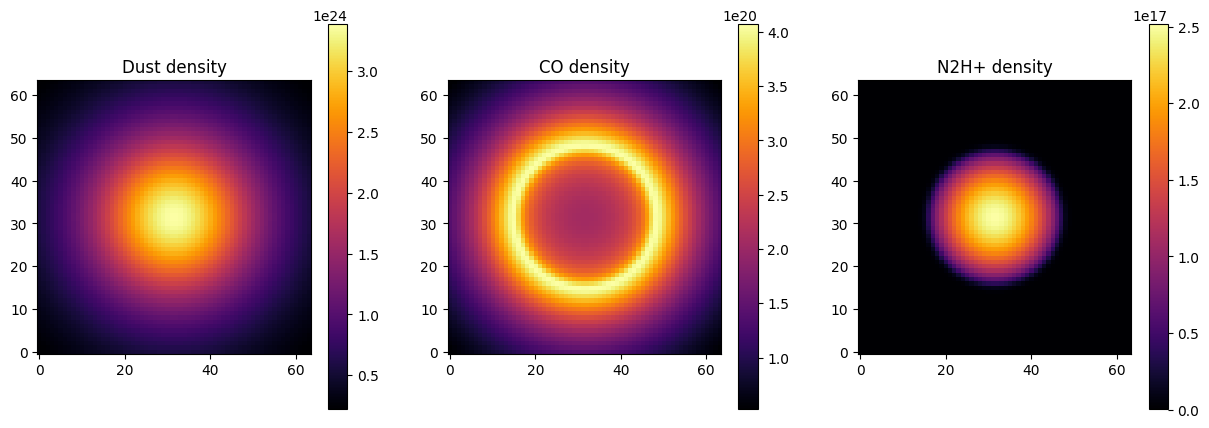

In [414]:
plt.figure(figsize=(15, 5))
plt.subplot(131)    
im = plt.imshow(np.sum(dust_cube, axis=0) * dr * 3.0857E+18, origin="lower", cmap="inferno")
plt.colorbar(im)
plt.title("Dust density")
plt.subplot(132)
im = plt.imshow(np.sum(CO.density_cube, axis=0) * dr * 3.0857E+18, origin="lower", cmap="inferno")
plt.colorbar(im)
plt.title("CO density")
plt.subplot(133)
im = plt.imshow(np.sum(N2H.density_cube, axis=0) * dr * 3.0857E+18, origin="lower", cmap="inferno")
plt.colorbar(im)
plt.title("N2H+ density")
plt.show()

---

# Cloud velocity generation

In [415]:
CO.velocity_cube = np.zeros((N, N, N))
N2H.velocity_cube = np.zeros((N, N, N))

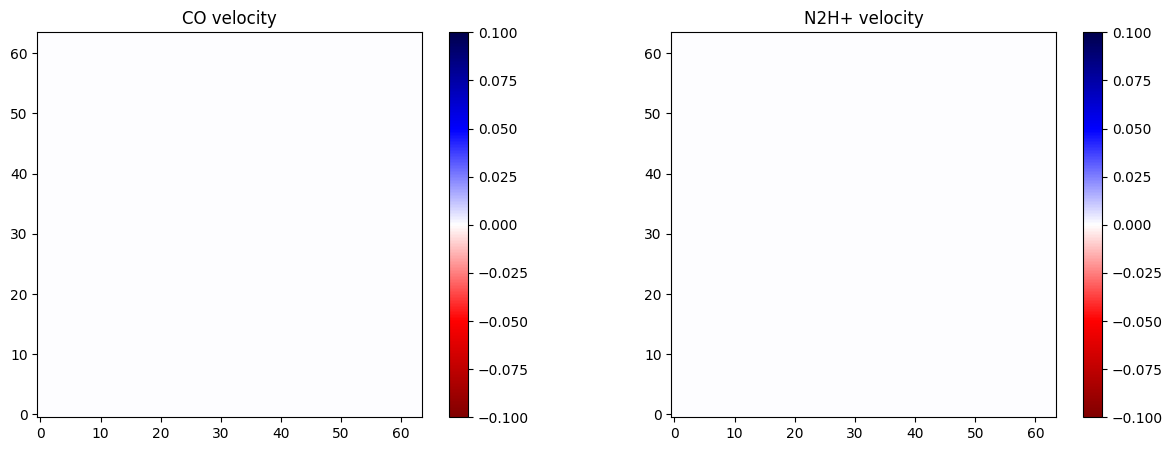

In [416]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
im = plt.imshow(CO.velocity_cube[N//2], origin="lower", cmap="seismic_r")
plt.colorbar(im)
plt.title("CO velocity")
plt.subplot(122)
im = plt.imshow(N2H.velocity_cube[N//2], origin="lower", cmap="seismic_r")
plt.colorbar(im)
plt.title("N2H+ velocity")
plt.show()

---

# Radiative transfer

### Emmissivity and absorption

In [417]:
for gas in [CO, N2H]:
    gas.emissivity_hypercube = np.zeros((N, N, N, len(gas.f)))
    gas.absorption_hypercube = np.zeros((N, N, N, len(gas.f)))

    for f in range(len(gas.f)):
        gas.absorption_hypercube[:,:,:,f] = h * gas.v0 / (4 * pi) * (gas.n1 * gas.B12 - gas.n2 * gas.B21) * gas.profile[f]
        gas.emissivity_hypercube[:,:,:,f] = h * gas.v0 / (4 * pi) * (gas.A21 * gas.n2) * gas.profile[f]

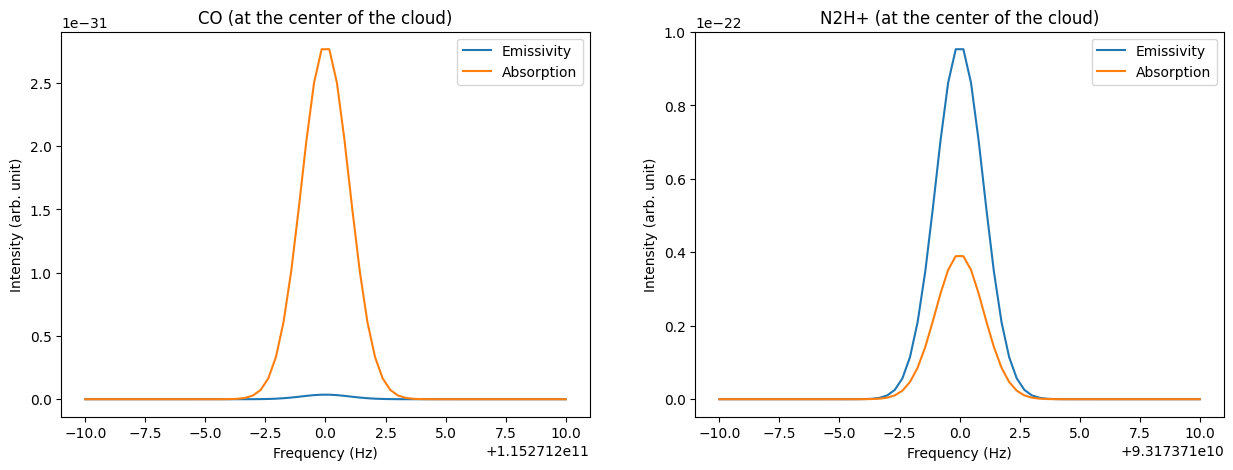

In [418]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(CO.f, CO.emissivity_hypercube[N//2,N//2,N//2,:], label="Emissivity")
plt.plot(CO.f, CO.absorption_hypercube[N//2,N//2,N//2,:], label="Absorption")
plt.title("CO (at the center of the cloud)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Intensity (arb. unit)")
plt.legend()
plt.subplot(122)
plt.plot(N2H.f, N2H.emissivity_hypercube[N//2,N//2,N//2,:], label="Emissivity")
plt.plot(N2H.f, N2H.absorption_hypercube[N//2,N//2,N//2,:], label="Absorption")
plt.title("N2H+ (at the center of the cloud)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Intensity (arb. unit)")
plt.legend()
plt.show()


5.4041888896557415e-53 6.99485580812045e-55
6.273123086464556e-57 1.5346887052751708e-56


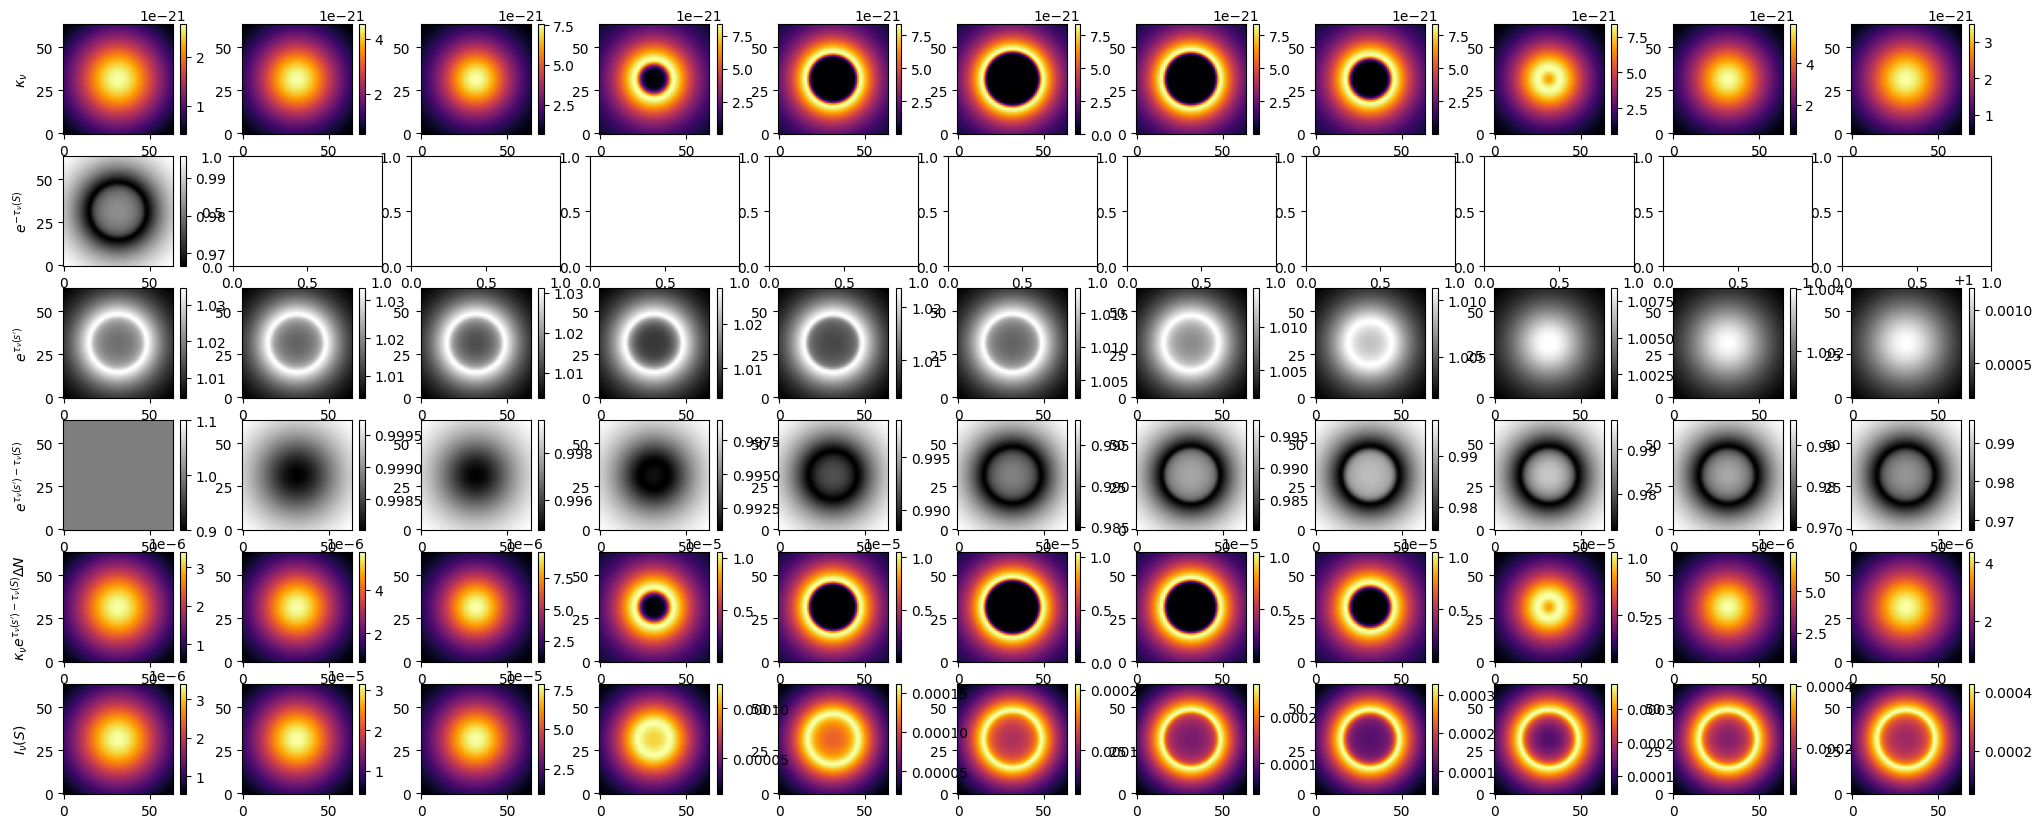

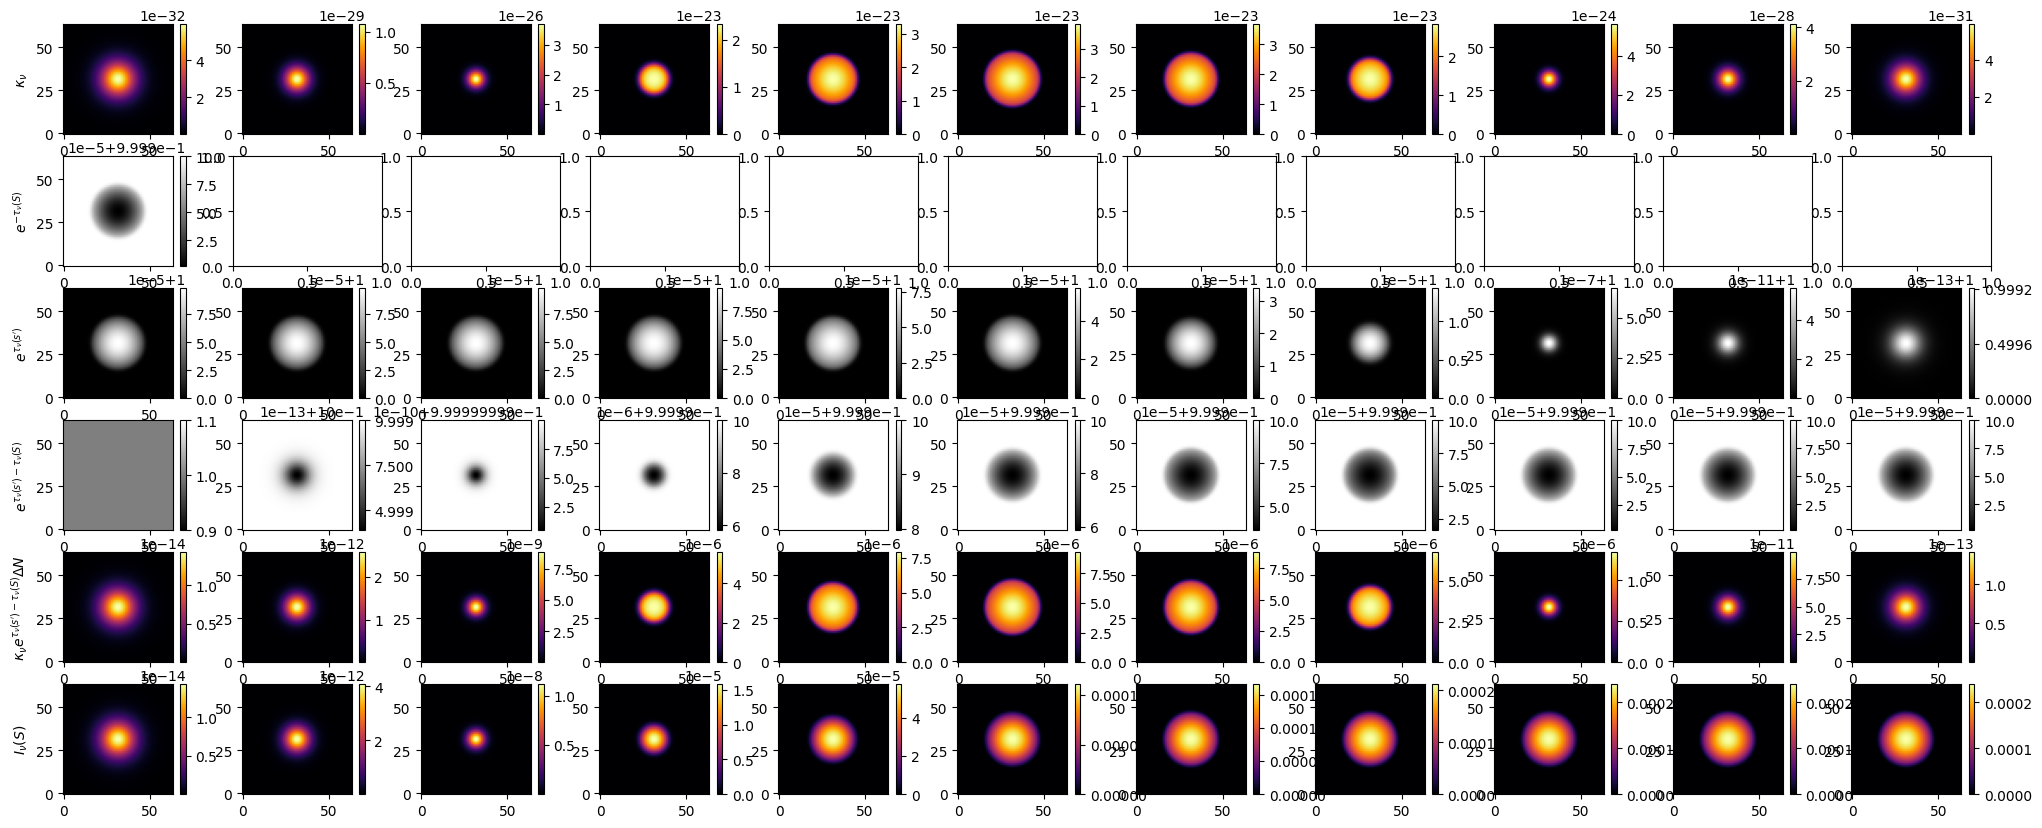

In [419]:
dN = dr * 3.0857E+18 # parsec to cm

for gas in [CO, N2H]:

    kappa = gas.absorption_hypercube
    epsilon = gas.emissivity_hypercube
    print(np.amin(kappa), np.amin(epsilon))

    # Computing TAU_S
    TAU = np.zeros((N, N, len(gas.f)))
    for Np in range(N):
        TAU += kappa[Np] * dN

    # Integrating the equation of radiative transfer
    gas.observation = np.zeros((N, N, len(gas.f)))
    
    fig, axs = plt.subplots(6, 11, figsize=(25, 10))
    cpt = 0
    axs[0,0].set_ylabel(r"$\kappa_\nu$")
    axs[1,0].set_ylabel(r"$e^{-\tau_\nu(S)}$")
    axs[2,0].set_ylabel(r"$e^{\tau_\nu(s')}$")
    axs[3,0].set_ylabel(r"$e^{\tau_\nu(s')-\tau_\nu(S)}$")
    axs[4,0].set_ylabel(r"$\kappa_\nu e^{\tau_\nu(s')-\tau_\nu(S)}\Delta N$")
    axs[5,0].set_ylabel(r"$I_\nu(S)$")
    im = axs[1, 0].imshow(np.exp(-TAU)[:,:,N//2], origin="lower", cmap="gray")
    plt.colorbar(im)

    for Np in range(0,N):

        # Computing Tau_s
        tau = np.zeros((N, N, len(gas.f)))
        for Npp in np.arange(Np, N):
            tau += kappa[Npp] * dN

        layer = epsilon[Np] * np.exp(tau - TAU) * dN
        gas.observation += layer

        if Np % (N//10) == 0:
            im = axs[0, cpt].imshow(kappa[Np][:,:,N//2], origin="lower", cmap="inferno")
            plt.colorbar(im)
            im = axs[2, cpt].imshow(np.exp(tau)[:,:,N//2], origin="lower", cmap="gray")
            plt.colorbar(im)
            im = axs[3, cpt].imshow(np.exp((tau - TAU))[:,:,N//2], origin="lower", cmap="gray")
            plt.colorbar(im)
            im = axs[4, cpt].imshow(layer[:,:,N//2], origin="lower", cmap="inferno")
            plt.colorbar(im)
            im = axs[5, cpt].imshow(gas.observation[:,:,N//2], origin="lower", cmap="inferno")
            plt.colorbar(im)
            cpt += 1

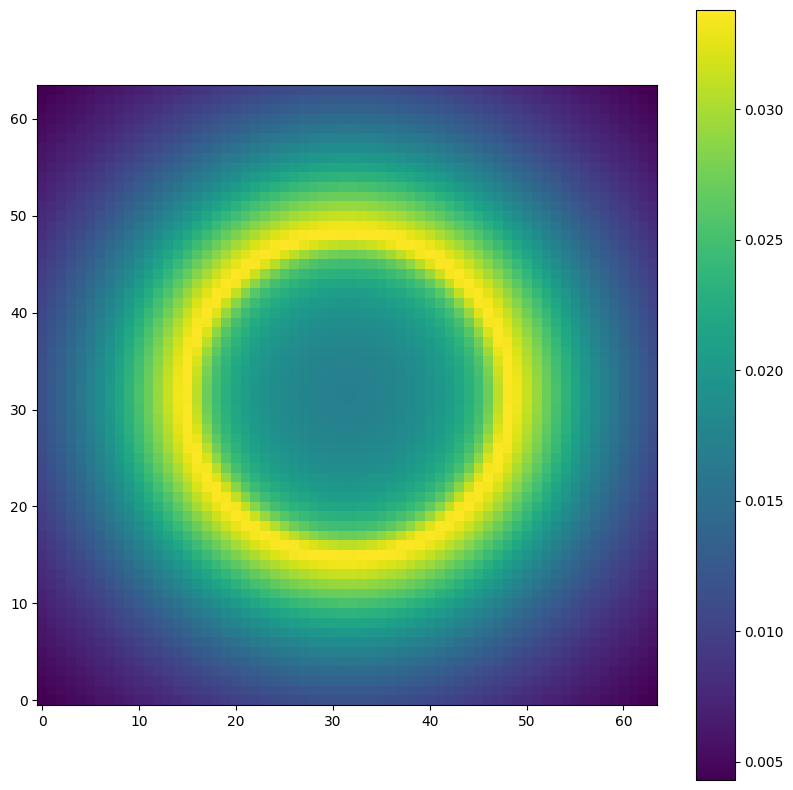

In [420]:
# Computing Tau_s
tau_s = np.zeros((N, N, len(gas.f)))
for i in range(s):
    tau_s += CO.absorption_hypercube[i] * dr * 3.0857E+18 # parsec to cm

plt.figure(figsize=(10, 10))
plt.imshow(tau_s[:,:,N//2], origin="lower")
plt.colorbar()
plt.show()

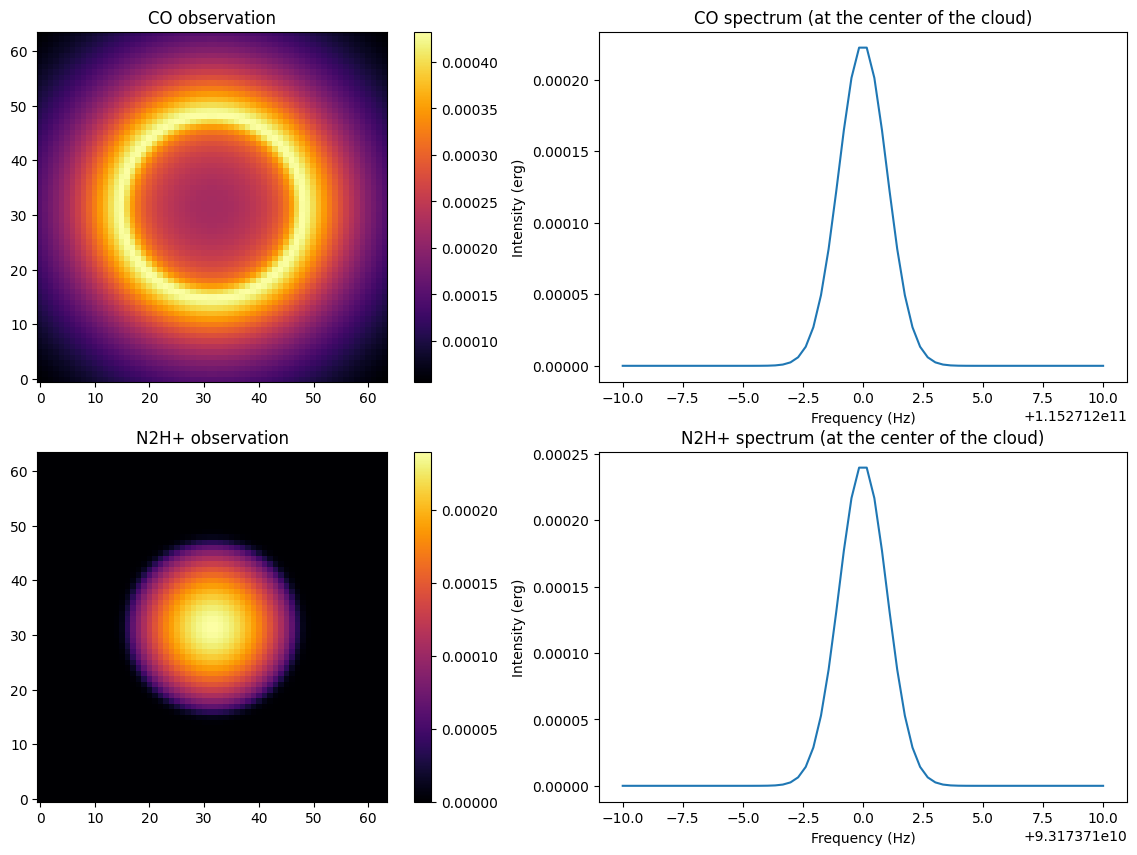

In [421]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(CO.observation[:,:,N//2], origin="lower", cmap="inferno")
plt.colorbar()
plt.title("CO observation")
plt.subplot(222)
plt.plot(CO.f, CO.observation[N//2,N//2,:])
plt.title("CO spectrum (at the center of the cloud)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Intensity (erg)")
plt.subplot(223)
plt.imshow(N2H.observation[:,:,N//2], origin="lower", cmap="inferno")
plt.colorbar()
plt.title("N2H+ observation")
plt.subplot(224)    
plt.plot(N2H.f, N2H.observation[N//2,N//2,:])
plt.title("N2H+ spectrum (at the center of the cloud)")
plt.xlabel("Frequency (Hz)")    
plt.ylabel("Intensity (erg)")
plt.show()